In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from utils.GraphWrapper import GraphWrapper as GW
import torch
from utils.data_loader import load_data

import scipy.sparse.csgraph as spgraph

plt.rcParams["font.family"] = "Times New Roman"

In [22]:
# load barabassi synthetic graph (CPA)
G = nx.powerlaw_cluster_graph(200, 2, .98, seed=0) #nx.barabasi_albert_graph(100, 3)
G2 = G.copy()
pos = nx.kamada_kawai_layout(G)

In [23]:
"""#load Stochastick block model from networkx
G = nx.stochastic_block_model([50, 50], [[0.6, 0.01], [0.01, 0.6]], seed=0)
G2 = G.copy()
pos = nx.kamada_kawai_layout(G)"""

'#load Stochastick block model from networkx\nG = nx.stochastic_block_model([50, 50], [[0.6, 0.01], [0.01, 0.6]], seed=0)\nG2 = G.copy()\npos = nx.kamada_kawai_layout(G)'

In [24]:
edge_list = np.array(G.edges())
edge_list = torch.Tensor(np.hstack((edge_list.T, edge_list.T[[1,0],:]))).long()
graph_er = GW(edgelist=edge_list)

graph_er2 = GW(edgelist=edge_list)

Loaded Graph with 200 nodes and 396 edges - L computation mode: exact
Loaded Graph with 200 nodes and 396 edges - L computation mode: exact


In [25]:
R = graph_er.get_effective_resistance()
node_er = R.sum(axis=0)

In [26]:
degree = np.array([G.degree[i] for i in range(G.number_of_nodes())])*10

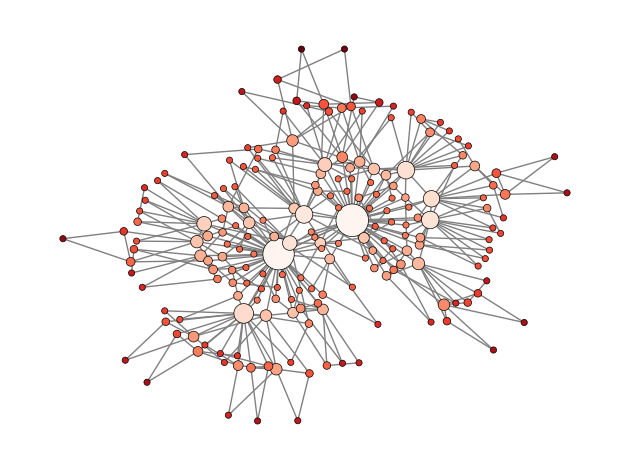

In [27]:
# plot graph with size of nodes representing and color representing the node total effective resistance
size = degree

nx.draw_networkx_nodes(G, pos, node_size=size, node_color=node_er, cmap=plt.cm.Reds, edgecolors='black', linewidths=0.5)
nx.draw_networkx_edges(G, pos, edge_color='grey')
plt.axis('off')
plt.tight_layout()
plt.show()


In [28]:
N_ITERS = 20

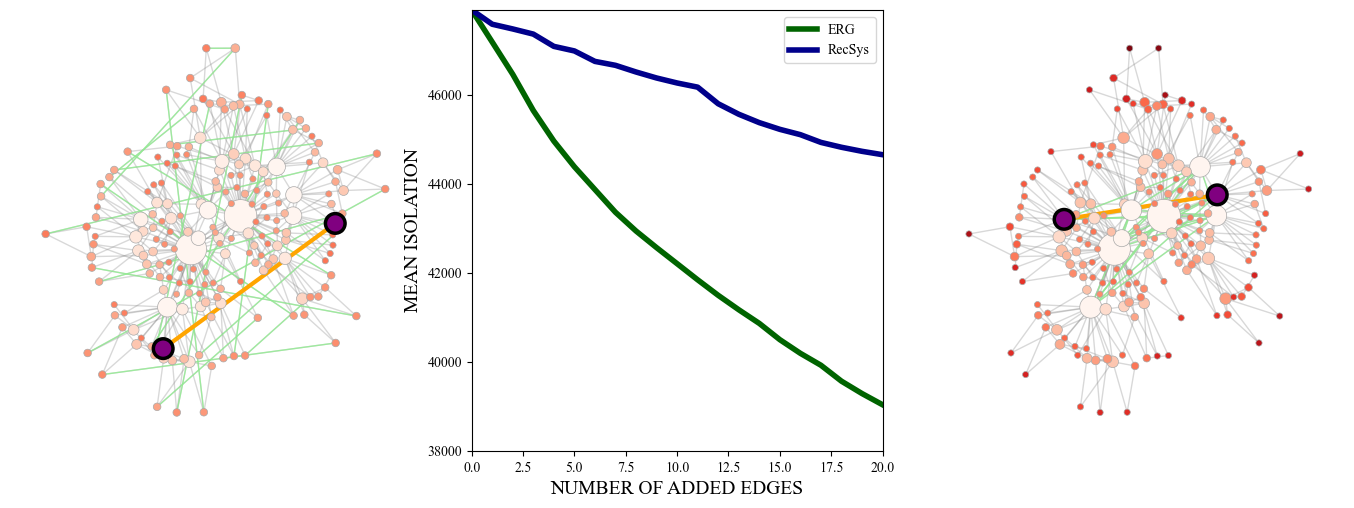

In [29]:
import matplotlib.animation as animation

# Initialize the figure and axes
fig, ax = plt.subplots(1,3, figsize=(14, 5))
ori_min_node_er = node_er.min() #0
ori_max_node_er = node_er.max()
ori_total_er = R.sum()
#sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=ori_min_node_er, vmax=ori_max_node_er))
#sm._A = []
#cbar = plt.colorbar(sm, ax=ax[1], orientation='horizontal', pad=0.01, shrink=0.5)

new_edges = []
total_er = []

new_edges2 = []
total_er2 = []
# Function to update the graph in each iteration
def update_graph(frame):

    # Add the link with maximum effective resistance
    R = graph_er.get_effective_resistance()
    argmax = (R*graph_er.compute_edge_mask()).argmax().item() #detach and cpu on call
    u, v = divmod(argmax, R.shape[0])
    if graph_er.is_edge(u,v):
        raise Exception('Edge already exists')
    else:
        graph_er.add_link(u,v)
        G.add_edge(u,v)
        new_edges.append((u,v))
    node_er = R.sum(axis=0)
    size = np.array([G.degree[i] for i in range(G.number_of_nodes())])*10
    
    # Clear the axes
    ax[0].clear()
    ax[0].axis('off')
    # Plot the graph with highlighted nodes and new link in red
    nx.draw_networkx_nodes(G, pos, node_size=size, node_color=node_er, cmap=plt.cm.Reds, edgecolors='darkgrey', linewidths=0.5,ax=ax[0],
                           vmin =ori_min_node_er , vmax=ori_max_node_er)
    nx.draw_networkx_nodes(G, pos, nodelist=[u,v], node_size=[200, 200], node_color='purple', edgecolors='black', linewidths=2.5,ax=ax[0])
    nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=.3,ax=ax[0])
    nx.draw_networkx_edges(G, pos, edgelist=new_edges, edge_color='lightgreen', width=1.0, alpha=.8,ax=ax[0])
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], edge_color='orange', width=3.0,ax=ax[0])
    # Set the title of the plot
    ax[1].set_title(f'Iteration {frame+1}')
    total_er.append(R.sum())


 
    # Add the link with minimum effective resistance
    R = graph_er2.get_effective_resistance()
    S = graph_er2.get_effective_resistance()
    S[torch.logical_not(graph_er2.compute_edge_mask())]=torch.inf
    argmin = S.argmin().item()
    u, v = divmod(argmin, R.shape[0])
    if graph_er2.is_edge(u,v):
        raise Exception('Edge already exists')
    else:
        graph_er2.add_link(u,v)
        G2.add_edge(u,v)
        new_edges2.append((u,v))
    node_er2 = R.sum(axis=0)
    size = np.array([G2.degree[i] for i in range(G2.number_of_nodes())])*10

    # Clear the axes
    ax[2].clear()
    ax[2].axis('off')
    # Plot the graph with highlighted nodes and new link in red
    nx.draw_networkx_nodes(G2, pos, node_size=size, node_color=node_er2, cmap=plt.cm.Reds, edgecolors='darkgrey', linewidths=0.5,ax=ax[2],
                           vmin =ori_min_node_er , vmax=ori_max_node_er)
    nx.draw_networkx_nodes(G2, pos, nodelist=[u,v], node_size=[200, 200], node_color='purple', edgecolors='black', linewidths=2.5,ax=ax[2])
    nx.draw_networkx_edges(G2, pos, edge_color='grey', alpha=.3,ax=ax[2])
    nx.draw_networkx_edges(G2, pos, edgelist=new_edges2, edge_color='lightgreen', width=1.0, alpha=.8,ax=ax[2])
    nx.draw_networkx_edges(G2, pos, edgelist=[(u,v)], edge_color='orange', width=3.0, ax=ax[2])
    total_er2.append(R.sum())


    # Plot the total effective resistance
    ax[1].clear()
    ax[1].plot(total_er, color='darkgreen', label='ERG', linewidth=4)
    ax[1].plot(total_er2, color='darkblue', label='RecSys', linewidth=4)
    ax[1].set_xlabel('NUMBER OF ADDED EDGES', fontsize=14)
    ax[1].set_ylabel('MEAN ISOLATION', fontsize=14)

    ax[1].set_xlim(0, N_ITERS)
    ax[1].legend()
    ax[1].set_ylim(38000, ori_total_er)

    return fig, ax
    
plt.tight_layout()
# Create the animation
ani = animation.FuncAnimation(fig, update_graph, frames=range(N_ITERS), repeat=False, blit=False)
#Save the animation
ani.save('animation.gif', writer='pillow', fps=2)

# Display the animation
plt.show()


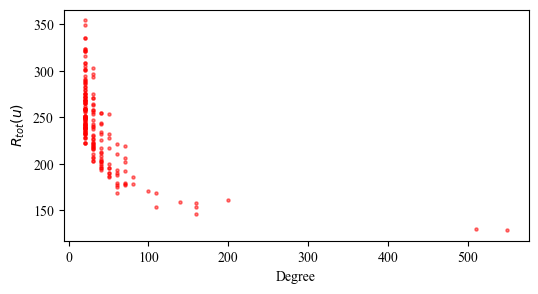

In [30]:
plt.figure(figsize=(6, 3))
plt.scatter(degree, node_er, s=5, c='r', marker='o', alpha=0.5)
plt.xlabel('Degree')
plt.ylabel('$R_{tot}(u)$')
plt.show()